## Simulation with Large Droplet

In [22]:
import pygame
import random
import math
import pandas as pd

class DataGenerator:
    """
    A class for generating data of moving circles with attraction points and a giant droplet.

    Methods:
    --------
    _generate_droplets() -> list of tuple of float
        Generates the circles.
    _remove_droplets() -> None
        Removes circles with a certain probability.
    _generate_attraction_points() -> list of tuple of float
        Generates the attraction points.
    _generate_rejection_points() -> list of tuple of float
        Generates the rejection points.
    _move_giant_droplet() -> None
        Moves the giant droplet.
    _move_attraction_points() -> None
        Moves the attraction points.
    _move_rejection_points() -> None
        Moves the rejection points.
    _move_circles(start: int, end: int, random_movement: bool=True) -> None
        Moves the circles.
    _detect_collisions(start: int, end: int) -> None
        Detects collisions between circles and between circles and walls.
    store_data(df_output) -> None
        Stores the data in a csv file.
    setup() -> None
        Sets up the simulation.
    simulate() -> None
        Simulates the movement of the circles.
    """

    def __init__(self):
        """
        Initializes the DataGenerator class.
        """
        # Output and length of simulation
        self.df = pd.DataFrame()
        self.df_output = "data.csv"
        self.number_of_recordings = 10

        # Simulation parameters
        self.number_of_frames = 1000

        # Pygame parameters
        self.pygame = True
        self.screen_width = 800
        self.screen_height = 800

        # Droplet parameters
        self.random_movement = True
        self.intrinsic_movement = True
        self.num_cells_ratios = [0.7, 0.29, 0.01]
        self.num_droplets = 900
        self.droplet_radius = 11
        self.max_random_velocity = 0.1
        self.max_intrinsic_velocity = 0.1
        self.disappearing_droplets = True
        self.disappear_probability = 0.01

        # Attraction point (positive focal point) parameters
        self.attraction_points = True
        self.attraction_movement = True
        self.num_attractions = 15
        self.attraction_radius = 80
        self.attraction_strength = 0.2
        self.attraction_strength_droplets = 0.03
        self.attraction_speed = 1

        # Rejection point (negative focal point) parameters
        self.rejection_points = False
        self.rejection_movement = False
        self.num_rejections = 10
        self.rejection_radius = 80
        self.rejection_strength = 0.2
        self.rejection_strength_droplets = 0.03
        self.rejection_speed = 1

        # Giant droplet parameters
        self.larger_droplet = True
        self.larger_droplet_radius = 80
        self.larger_droplet_speed_x = 0.2
        self.larger_droplet_speed_y = 0.01
        

    def _remove_droplets(self) -> None:
        """
        Removes circles with a certain probability.
        """
        # Remove droplets with certain probability
        if random.uniform(0,1) < self.disappear_probability:
            self.circles[self.num_droplets-1] = (0,0,0,0)
            self.num_droplets -= 1

        if self.pygame and self.num_droplets == 0:
            pygame.quit()

    def _generate_droplets(self) -> list:
        """
        Generates the circles.

        Returns:
        --------
        circles : list of tuple of float
            The circles.
        """
        circles = []
        for i in range(self.num_droplets):
            x = random.randint(self.droplet_radius, self.screen_width - self.droplet_radius)
            y = random.randint(self.droplet_radius, self.screen_height - self.droplet_radius)

            if self.intrinsic_movement:
                dx = random.uniform(-self.max_intrinsic_velocity, self.max_intrinsic_velocity)
                dy = random.uniform(-self.max_intrinsic_velocity, self.max_intrinsic_velocity)
            else:
                dx = 0
                dy = 0
            circles.append((x, y, dx, dy))
        return circles

    def _generate_attraction_points(self) -> list:
        """
        Generates the attraction points.

        Returns:
        --------
        attractions : list of tuple of float
            The attraction points.
        """
        attractions = []
        for i in range(self.num_attractions):
            x = random.randint(self.attraction_radius, self.screen_width - self.attraction_radius)
            y = random.randint(self.attraction_radius, self.screen_height - self.attraction_radius)
            dx = random.uniform(-self.attraction_speed, self.attraction_speed)
            dy = random.uniform(-self.attraction_speed, self.attraction_speed)
            attractions.append((x, y, dx, dy))
        return attractions
    
    def _generate_rejection_points(self) -> list:
        """
        Generates the rejection points.

        Returns:
        --------
        rejections : list of tuple of float
            The rejection points.
        """
        rejections = []
        for i in range(self.num_rejections):
            x = random.randint(self.rejection_radius, self.screen_width - self.rejection_radius)
            y = random.randint(self.rejection_radius, self.screen_height - self.rejection_radius)
            dx = random.uniform(-self.rejection_speed, self.rejection_speed)
            dy = random.uniform(-self.rejection_speed, self.rejection_speed)
            rejections.append((x, y, dx, dy))
        return rejections

    def _move_giant_droplet(self) -> None:
        """
        Moves the giant droplet.
        """
        self.giant_droplet_x += self.giant_droplet_dx
        self.giant_droplet_y += self.giant_droplet_dy

    def _move_attraction_points(self) -> None:
        """
        Moves the attraction points.
        """
        for i in range(self.num_attractions):
            x, y, dx, dy = self.attractions[i]

            if x < self.attraction_radius or x > self.screen_width - self.attraction_radius:
                dx = -dx
            if y < self.attraction_radius or y > self.screen_height - self.attraction_radius:
                dy = -dy

            x += dx
            y += dy
            self.attractions[i] = (x, y, dx, dy)

    def _move_rejection_points(self) -> None:
        """
        Moves the rejection points.
        """
        for i in range(self.num_rejections):
            x, y, dx, dy = self.rejections[i]

            if x < self.rejection_radius or x > self.screen_width - self.rejection_radius:
                dx = -dx
            if y < self.rejection_radius or y > self.screen_height - self.rejection_radius:
                dy = -dy

            x += dx
            y += dy
            self.rejections[i] = (x, y, dx, dy)

    def _move_circles(self, start: int, end: int) -> None:
        """
        Moves the circles.

        Parameters:
        -----------
        start : int
            The starting index of the circles to move.
        end : int
            The ending index of the circles to move.
        random_movement : bool, optional
            Whether the circles should move randomly or not. Default is True.
        """
        for i in range(start, end):
            x, y, dx, dy = self.circles[i]

            # Apply intrinsic velocities
            x += dx
            y += dy

            # Apply random movement
            if self.random_movement:
                x += random.uniform(-self.max_random_velocity, self.max_random_velocity)
                y += random.uniform(-self.max_random_velocity, self.max_random_velocity)

            # Apply attraction forces
            if self.attraction_points:
                for ax, ay, _, _ in self.attractions:
                    dist = math.sqrt((x - ax) ** 2 + (y - ay) ** 2)
                    if dist < self.attraction_radius:
                        angle = math.atan2(ay - y, ax - x)
                        x += self.attraction_strength * math.cos(angle)
                        y += self.attraction_strength * math.sin(angle)
            
            # Apply rejection forces
            if self.rejection_points:
                for rx, ry, _, _ in self.rejections:
                    dist = math.sqrt((x - rx) ** 2 + (y - ry) ** 2)
                    if dist < self.rejection_radius:
                        angle = math.atan2(ry - y, rx - x)
                        x -= self.rejection_strength * math.cos(angle)
                        y -= self.rejection_strength * math.sin(angle)

            # Check for collisions with other circles
            for j in range(self.num_droplets):
                x2, y2, dx2, dy2 = self.circles[j]
                dist = math.sqrt((x - x2) ** 2 + (y - y2) ** 2)
                
                if dist < self.droplet_radius * 2:
                    # Adjust velocities to prevent overlap
                    
                    diff_x = x2 - x
                    diff_y = y2 - y
                    ndiff_x = diff_x / dist
                    ndiff_y = diff_y / dist
                    x2 = x + ndiff_x * self.droplet_radius * 2
                    y2 = y + ndiff_y * self.droplet_radius * 2

                    self.circles[j] = (x2, y2, dx2, dy2)
                    
            # Avoid the giant droplet
            if self.larger_droplet:
                dist = math.sqrt((x - self.giant_droplet_x) ** 2 + (y - self.giant_droplet_y) ** 2)
                if dist < self.larger_droplet_radius + self.droplet_radius:
                    diff_x = x - self.giant_droplet_x
                    diff_y = y - self.giant_droplet_y
                    ndiff_x = diff_x / dist
                    ndiff_y = diff_y / dist
                    x = self.giant_droplet_x + ndiff_x * (self.larger_droplet_radius + self.droplet_radius)
                    y = self.giant_droplet_y + ndiff_y * (self.larger_droplet_radius + self.droplet_radius)

                    # Alternative method
                    # angle = math.atan2(y - self.giant_droplet_y, x - self.giant_droplet_x)
                    # x = self.giant_droplet_x + math.cos(angle) * (self.larger_droplet_radius + self.droplet_radius)
                    # y = self.giant_droplet_y + math.sin(angle) * (self.larger_droplet_radius + self.droplet_radius)

            # Check for collisions with walls
            if x < self.droplet_radius:
                x = self.droplet_radius
                dx = -dx
            elif x > self.screen_width - self.droplet_radius:
                x = self.screen_width - self.droplet_radius
                dx = -dx

            if y < self.droplet_radius:
                y = self.droplet_radius
                dy = -dy
            elif y > self.screen_height - self.droplet_radius:
                y = self.screen_height - self.droplet_radius
                dy = -dy

            # Move circles
            self.circles[i] = (x, y, dx, dy)


    def store_data(self, df_output):
        """
        Stores the data in a csv file.
        """
        self.df.to_csv(df_output)


    def setup(self) -> None:
        """
        Sets up the simulation.
        """
        # Generate a list of 100 entries with the specified probabilities
        self.num_cells_list = random.choices([0, 1, 2], weights=self.num_cells_ratios, k=self.num_droplets)# col of dataframe should be initialized randomly with probabilities num_cells
        self.df["num_cells"] = self.num_cells_list

        # Initialize Pygame
        if self.pygame:
            pygame.init()

            # Set up the screen
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            pygame.display.set_caption("Moving Circles")

            # Set up the clock
            self.clock = pygame.time.Clock()

        # Set up the circles
        self.circles = self._generate_droplets()

        # Set up the attraction points
        if self.attraction_points:
            self.attractions = self._generate_attraction_points()
        
        if self.rejection_points:
            self.rejections = self._generate_rejection_points()

        # Set up the giant droplet
        if self.larger_droplet:
            self.giant_droplet_x = self.screen_width // 5
            self.giant_droplet_y = self.screen_height // 2
            self.giant_droplet_dx = self.larger_droplet_speed_x
            self.giant_droplet_dy = self.larger_droplet_speed_x

        # Set up the colors
        self.bg_color = (255, 255, 255)
        self.circle_color = (0, 0, 255)
        self.attraction_color = (255, 0, 0)
        self.giant_droplet_color = (0, 255, 0)

    def simulate(self) -> None:
        """
        Simulates the movement of the circles.
        """
        # Main game loop
        running = True
        counter = 0

        # Run as long as the counter is running, the number of frames is reached and there are still droplets
        while running and counter < self.number_of_frames and self.num_droplets > 0:
            # Handle events
            if self.pygame:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                        continue

            # Move the giant droplet
            if self.larger_droplet:
                self._move_giant_droplet()

            # Remove droplets
            if self.disappearing_droplets:
                self._remove_droplets()

            # Move the circles
            self._move_circles(0, self.num_droplets)

            # Move the attraction points
            if self.attraction_points and self.attraction_movement:
                self._move_attraction_points()

            # Move the rejection points
            if self.rejection_points and self.rejection_movement:
                self._move_rejection_points()

            # Update dataframe with position data
            if counter % (self.number_of_frames // self.number_of_recordings) == 0:
                self.df["x"+str(counter)] = [x for x, _, _, _ in self.circles]
                self.df["y"+str(counter)] = [y for _, y, _, _ in self.circles]

            # Draw the circles and attractions
            if self.pygame:
                self.screen.fill(self.bg_color)
                for x, y, _, _ in self.circles:
                    pygame.draw.circle(self.screen, self.circle_color, (x, y), self.droplet_radius)

                if self.attraction_points:
                    for x, y, _, _ in self.attractions:
                        pygame.draw.circle(self.screen, self.attraction_color, (x, y), self.attraction_radius, 1)
                
                if self.rejection_points:
                    for x, y, _, _ in self.rejections:
                        pygame.draw.circle(self.screen, self.attraction_color, (x, y), self.rejection_radius, 1)
                        
                if self.larger_droplet:
                    pygame.draw.circle(self.screen, self.giant_droplet_color, (int(self.giant_droplet_x), int(self.giant_droplet_y)), self.larger_droplet_radius, 1)
                pygame.display.flip()

                # Limit the frame rate
                self.clock.tick(60)

            # Update counter
            counter += 1

        # Clean up
        if self.pygame:
            pygame.quit()


In [8]:
data_generator = DataGenerator()
data_generator.random_movement = False
data_generator.attraction_points = True
data_generator.attraction_movement = True
data_generator.larger_droplet = True
data_generator.disappearing_droplets = True
data_generator.disappear_probability = 0.005
data_generator.number_of_frames = 100
data_generator.num_droplets = 500
data_generator.droplet_radius = 14
data_generator.pygame = True
data_generator.setup()
data_generator.simulate()
data_generator.store_data("data.csv")

## Simulation with only random noise and intrinsic movement

In [21]:
data_generator = DataGenerator()
data_generator.random_movement = True
data_generator.intrinsic_movement = True
data_generator.attraction_points = False
data_generator.attraction_movement = False
data_generator.larger_droplet = False
data_generator.disappearing_droplets = False
data_generator.number_of_frames = 100
data_generator.num_droplets = 500
data_generator.droplet_radius = 14
data_generator.attraction_points = True
data_generator.rejection_strength = 2
data_generator.rejection_points = True
data_generator.rejection_movement = True
data_generator.max_intrinsic_velocity = 1
data_generator.max_random_velocity = 0.1
data_generator.pygame = True
data_generator.setup()
data_generator.simulate()
data_generator.store_data("data.csv")

## Simulation with Attraction/Repulsion Points

## Global Transformations

In [70]:
# Generate 200 uniformly distributed points in 2D
import numpy as np
import matplotlib.pyplot as plt

points = np.random.uniform(low=0.0, high=1.0, size=(500, 2))

In [71]:
points

array([[2.39783876e-01, 8.92143986e-01],
       [4.07797332e-01, 7.51841895e-01],
       [5.67449784e-01, 4.56165986e-01],
       [3.04318570e-01, 9.47954124e-01],
       [3.48336080e-01, 6.79103360e-01],
       [5.33212687e-01, 4.07447099e-01],
       [3.10327490e-01, 2.35104505e-02],
       [8.55415092e-01, 4.52371899e-01],
       [9.69194308e-01, 4.90882060e-01],
       [4.88484093e-01, 3.56238496e-01],
       [3.07412510e-01, 7.72918539e-01],
       [2.55940691e-01, 4.48347317e-01],
       [9.62650126e-02, 5.21748653e-01],
       [9.71019788e-01, 7.52333717e-01],
       [5.79297573e-01, 7.54499884e-02],
       [6.38840660e-01, 1.47254963e-01],
       [9.46091870e-01, 1.17019837e-01],
       [6.72559286e-01, 7.10361446e-01],
       [1.67192339e-01, 5.71716814e-01],
       [3.95607078e-02, 9.07415432e-02],
       [1.56530777e-01, 8.02839867e-01],
       [7.01219207e-01, 2.98872998e-01],
       [3.15605895e-01, 8.18315647e-01],
       [6.78047602e-03, 8.59608871e-01],
       [3.498899

In [137]:
import math
import random

# Define the radius and minimum distance between circles
radius = 0.013
min_distance = radius * 2
num_circles = 1000
# Define the grid cell size
cell_size = min_distance / math.sqrt(2)

# Define the grid dimensions
grid_size = 5
grid_width = math.ceil(grid_size / cell_size)
grid_height = math.ceil(grid_size / cell_size)

# Initialize the grid with empty cells
grid = [[None] * grid_height for _ in range(grid_width)]

# Initialize the active list with a random point
active = [(random.uniform(radius, 1 - radius), random.uniform(radius, 1 - radius))]

# Initialize the circles list
circles = []

# Iterate until the active list is empty
while active or len(circles) < num_circles:
    if active == []:
        active = [(random.uniform(radius, 1 - radius), random.uniform(radius, 1 - radius))]
    # Choose a random active point
    index = random.randint(0, len(active) - 1)
    x, y = active[index]
    # Generate up to 30 new points around the active point
    found = False
    for _ in range(500):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(min_distance, 2 * min_distance)
        new_x = x + math.cos(angle) * distance
        new_y = y + math.sin(angle) * distance
        # Check if the new point is within the bounds of the grid
        if new_x < radius or new_x > 1 - radius or new_y < radius or new_y > 1 - radius:
            continue
        # Calculate the grid cell coordinates of the new point
        cell_x = int(new_x // cell_size)
        cell_y = int(new_y // cell_size)
        # Check if the new point is too close to existing points
        close = False
        for i in range(max(0, cell_x - 2), min(grid_width, cell_x + 3)):
            for j in range(max(0, cell_y - 2), min(grid_height, cell_y + 3)):
                other_point = grid[i][j]
                if other_point is None:
                    continue
                other_x, other_y = other_point
                dist = math.sqrt((new_x - other_x) ** 2 + (new_y - other_y) ** 2)
                if dist < min_distance:
                    close = True
                    break
            if close:
                break
        if not close:
            # Add the new point to the active list and circles list
            active.append((new_x, new_y))
            circles.append((new_x, new_y, radius))
            grid[cell_x][cell_y] = [new_x, new_y]
            found = True
            break
    # Remove the active point if no new points were found
    if not found:
        active.pop(index)

circles = np.array(circles)[:,:2]

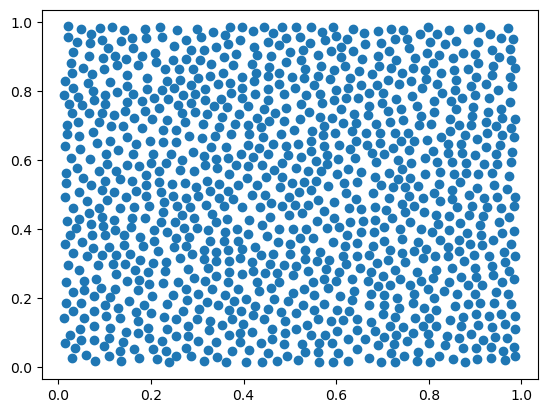

In [138]:
plt.scatter(circles[:,0], circles[:,1])


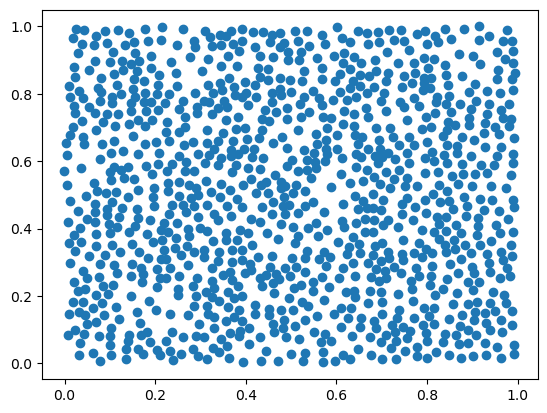

In [139]:
circles_transf = circles.copy()

# Apply some random noise to the points
noise = np.random.normal(scale=0.002, size=circles.shape)
circles_transf += noise

# Apply some attraction forces between the points
num_attractions = 200
attraction_radius = 0.1
attraction_strength = 0.004

# Generate the attraction points
attractions = np.random.uniform(size=(num_attractions, 2))

# Apply attraction forces
for i in range(len(circles_transf)):
    for j in range(len(attractions)):
        dist = np.linalg.norm(circles_transf[i] - attractions[j])
        if dist < attraction_radius:
            angle = math.atan2(attractions[j,1] - circles_transf[i,1], attractions[j,0] - circles_transf[i,0])
            circles_transf[i] -= attraction_strength * np.array([math.cos(angle), math.sin(angle)])

plot = plt.scatter(circles_transf[:,0], circles_transf[:,1])

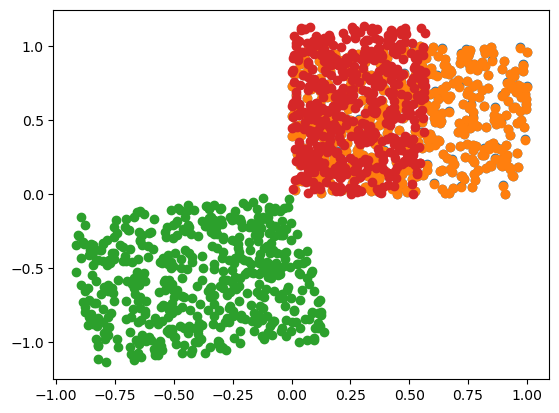

In [119]:
# Apply a bunch of transformations on the points
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Define the number of points
num_points = 500

# Generate a bunch of random points
points = np.random.uniform(low=0.0, high=1.0, size=(num_points, 2))

# Apply a random rotation
angle = random.uniform(0, 2 * math.pi)
rotation = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
points_rot = np.dot(points, rotation)

# Apply a random translation
translation = np.random.uniform(low=-0.2, high=0.2, size=(2,))
points_trans = points + translation

# Apply a random scaling
scale = np.random.uniform(low=0.5, high=1.5, size=(2,))
points_scaled = points * scale

# Apply a random shear
shear = np.random.uniform(low=-0.5, high=0.5)
shear_matrix = np.array([[1, shear], [0, 1]])
points_shear = np.dot(points, shear_matrix)

# Plot the points
plt.scatter(points[:,0], points[:,1])
plt.scatter(points_shear[:,0], points_shear[:,1])
plt.scatter(points_rot[:,0], points_rot[:,1])
plt.scatter(points_scaled[:,0], points_scaled[:,1]) 
